In [8]:
# !/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv


# 3DVar nonlinear model assumption



def L96(Xa,F):

    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def Forecast(Xa,m,b,L):
    h = 0.05 
    F = 8.0
        
    Xf = np.empty((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    #dX = [Xf[:,k]-Xf_ for k in range(m)]
    dXf = Xf - Xf_.reshape(-1,1)
    #dXf = np.array(dX).reshape(m,N).T
    dXf = dXf*b/np.sqrt(m-1)
    #print(dXf)
    Pf = dXf @ dXf.T
    #Pf = Pf*L
    
    return Xf,Pf,dXf,Xf_

def Analysis(Xf,Pf,dXf,Xf_,y,m,a,mask,L):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,mask,axis=0) #観測欠損 #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    R_inv = np.linalg.inv(R)
    d = y - H @ Xf_
    
    dY = H @ dXf
    
    alpha0 = np.zeros(m)
    alpha = CG(alpha0,R_inv,dY,d)
    Xa_ = dXf@alpha + Xf_
    
    #カルマンゲインの導出
    A = H @ Pf @ H.T + R
    A_inv = np.linalg.inv(A)
    K = Pf @ H.T @ A_inv
    #K = K*L
    
    E = np.eye(m)
    TT = E - dY.T @ np.linalg.inv(dY @ dY.T+(m-1)*R) @ dY
    #print(TT)
    
    la,v = np.linalg.eigh(TT)
    #print(v)
    D = np.diag(np.sqrt(la))
    #print(D)
    U = np.array(v).reshape(m,m)
    
    T = U @ D
    #print(T @ T.T)
    dXa = dXf @ T
    Xa = dXa*np.sqrt(m-1) + Xa_.reshape(-1,1)
    
    Pa = dXa @ dXa.T
    
    return Xa,Pa,Xa_

def J(alpha,R_inv,HdX,d):
    
    return alpha.T@alpha/2 + (HdX@alpha-d).T@R_inv@(HdX@alpha-d)/2

def jacobi(alpha,R_inv,HdX,d):
    
    return alpha + HdX.T@R_inv@(HdX@alpha-d)

def CG(alpha0,R_inv,HdX,d):
    d0 = -jacobi(alpha0,R_inv,HdX,d)
    for k in range(1000):
        #alpha = golden_section(d0,dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
        a = 0.01
        alpha = alpha0 + a*d0
        d1 = jacobi(alpha,R_inv,HdX,d)
        #err = np.sqrt(np.sum(d**2))
        #print(k,err)          
        if(np.sqrt(np.sum(d1**2))<0.001):
            #print(k,"end")
            break
        p = -d1 + (np.dot(d1.T,d1)/np.dot(d0.T,d0))*d0
        alpha0 = alpha
        d0 = p
    return alpha


2.0 1.1


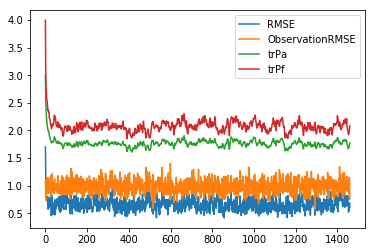

0.6553455919304104


In [11]:
t = 1460
N = 40
m = 40
h = 0.05 
F = 8.0
#初期値
Xa = np.empty((N,m))
Xc = np.random.rand(N,m)
for j in range(500):
    Xb = Rungekutta4(Xc,h,F)
    Xc = Xb
Xa = Xb
#plt.plot(Xa[:,9])
#plt.plot(Xa[:,8])
#plt.show()

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
A = []
B = []
for i in range(1):
    a = 0
    sigma = 2.0*(i+1)
    for j in range(1):
        b = 1.1
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        for k in range(t):
            
            mask = np.random.choice(40,a,replace=False)
            y_ =np.delete(Y[k],mask)
            D=np.zeros((N,N-a))
            L=np.zeros((N,N-a))
            r=0
            obs=np.arange(N)
            obs=np.delete(obs,mask)
            for s in range(N):
                for u in range(N-a):
                    D[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
            d0 = 2*np.sqrt(10/3)*sigma
            r0 = np.exp(-d0**2/(2*sigma**2))
            L = np.exp(-D**2/(2*sigma**2))
            L[L<r0]=0
            """
            for s in range(N):
                for u in range(N-a):
                    if(D[s,u]<2*np.sqrt(10/3)*sigma):
                        L[s,u] = np.exp(-D[s,u]**2/(2*sigma**2))
                    else:
                        L[s,u] = 0
            """
            L = np.eye(N)
            (Xf,Pf,dXf,Xf_) = Forecast(Xa,m,b,L)
            (Xa,Pa,Xa_) = Analysis(Xf,Pf,dXf,Xf_,y_,m,a,mask,L)
            #print(Xf)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k]
            Y1 = Y[k]
            rmse = np.sqrt(np.sum((Xa-X1)*(Xa-X1),axis=0)/N)
            rmsef = np.sqrt(np.sum((Xf-X1)*(Xf-X1),axis=0)/N)
            rmse_ = np.sqrt(np.sum((Xa_-X1)*(Xa_-X1))/N) 
            rmseo = np.sqrt(np.sum((Y1-X1)*(Y1-X1))/N)
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
             #   print(k)
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A.append(sigma)
        B.append(b)
        print(sigma,b)
#print(trPa)
#print(R)
#plt.plot(A,RMSE,label="RMSE")
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
#plt.xlabel("observation missing")
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("SRF.jpg")
plt.show()
print(np.mean(R_[500:]))
df = pd.DataFrame(RMSE)
df.to_csv("SRFB-localize.csv")

In [19]:
# !/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv


# 4DVar nonlinear model assumption



def L96(Xa,F):

    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb

def Forecast(Xa,m,b,L):
    h = 0.05 
    F = 8.0
        
    Xf = np.empty((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    #dX = [Xf[:,k]-Xf_ for k in range(m)]
    dXf = Xf - Xf_.reshape(-1,1)
    #dXf = np.array(dX).reshape(m,N).T
    dXf = dXf*b/np.sqrt(m-1)
    #print(dXf)
    Pf = dXf @ dXf.T
    #Pf = Pf*L
    
    return Xf,Pf,dXf,Xf_

def Analysis(Xf,Pf,dXf,Xf_,y,m,a,mask,b,L,a_window):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,mask,axis=0) #観測欠損 #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    R_inv = np.linalg.inv(R)
    
    Fcst = [] #基本場(アンサンブル)
    Fcst_ = [] #基本場（平均）
    dep = []
    xb = Xf
    xb_ = Xf_
    Fcst.append(xb)
    Fcst_.append(xb_)
    d = y - H @ Xf_
    dep.append(d)
    for k in range(a_window):
        X1 = Rungekutta4(xb,h,F)
        X1_ = Rungekutta4(xb_,h,F)
        Fcst.append(X1)
        Fcst_.append(X1_)
        d = y - H @ X1_
        dep.append(d)
        xb = X1
        xb_ = X1_
     
    dY = H @ dXf
    M = [] #TLM assumption
    M.append(dXf)
    for k in range(1,a_window+1):
        Mdx = (Fcst[k]-Fcst_[k].reshape(-1,1))*b/np.sqrt(m-1)
        M.append(Mdx)
    #print(len(M))
    
    alpha0 = np.zeros(m)
    alpha = CG(alpha0,R_inv,H,M,dep)
    X = dXf@alpha
    Xa_ = X + Xf_
    
    #カルマンゲインの導出
    A = H @ Pf @ H.T + R
    A_inv = np.linalg.inv(A)
    K = Pf @ H.T @ A_inv
    #K = K*L
    
    E = np.eye(m)
    TT = E - dY.T @ np.linalg.inv(dY @ dY.T+(m-1)*R) @ dY
    #print(TT)
    
    la,v = np.linalg.eigh(TT)
    #print(v)
    D = np.diag(np.sqrt(la))
    #print(D)
    U = np.array(v).reshape(m,m)
    
    T = U @ D
    #print(T @ T.T)
    dXa = dXf @ T
    Xa = dXa*np.sqrt(m-1) + Xa_.reshape(-1,1)
    
    Pa = dXa @ dXa.T
    
    return Xa,Pa,Xa_

def J(alpha,R_inv,H,M,dep):
    j = 0
    for k in range(a_window+1):
    #    xk = Fcst[k]
    #    yk = y[k]
        dk = dep[k]
        MX = M[k]
        j += (H@MX@alpha-dk).T@R_inv@(H@MX@alpha-dk)/2
    return alpha.T@alpha/2 + j

def jacobi(alpha,R_inv,H,M,dep):
    
    p = np.zeros(N)
    for k in range(a_window+1):
    #    xk = Fcst[k]
    #    yk = y[k]
        dk = dep[k]
        MX = M[k]
    #    MkT = MT[k]
        p += (H@MX).T@R_inv@(H@MX@alpha-dk)
         
    return alpha + p

def CG(alpha0,R_inv,H,M,dep):
    d0 = -jacobi(alpha0,R_inv,H,M,dep)
    for k in range(1000):
        #alpha = golden_section(d0,dv0,U,R_inv,H,y,Fcst,M,MT,a_window)
        a = 0.01
        alpha = alpha0 + a*d0
        d1 = jacobi(alpha,R_inv,H,M,dep)
        #err = np.sqrt(np.sum(d**2))
        #print(k,err)          
        if(np.sqrt(np.sum(d1**2))<0.001):
            #print(k,"end")
            break
        p = -d1 + (np.dot(d1.T,d1)/np.dot(d0.T,d0))*d0
        alpha0 = alpha
        d0 = p
    return alpha


0 2.0 1.1


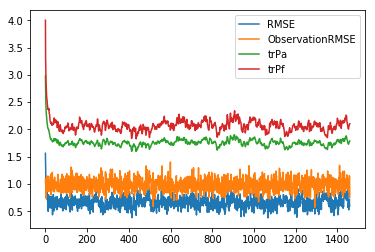

0.6562718744185824
1 2.0 1.1


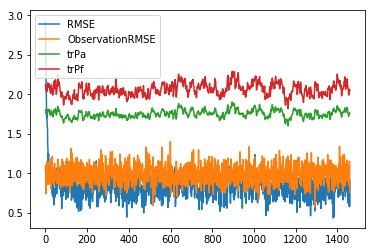

0.8116210702336301
2 2.0 1.1


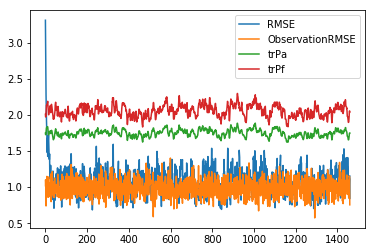

1.0836646515419293
3 2.0 1.1


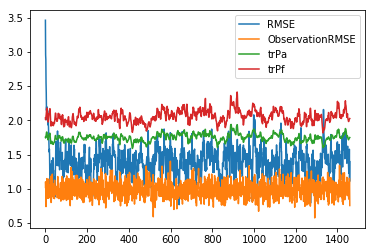

1.3948714009858019


C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract
C:\Users\saori\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in add


4 2.0 1.1


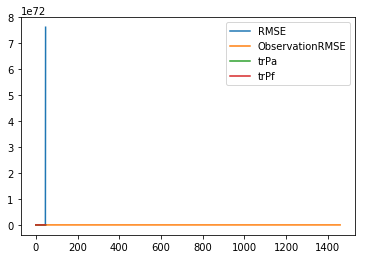

nan
5 2.0 1.1


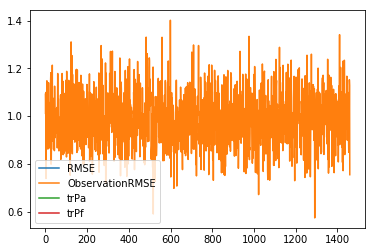

nan
6 2.0 1.1


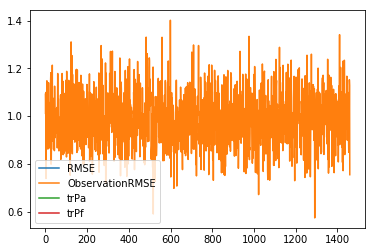

nan
7 2.0 1.1


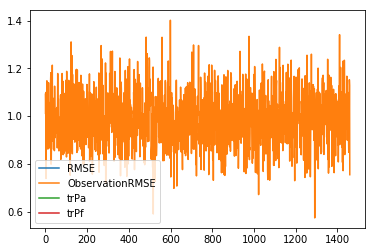

nan
8 2.0 1.1


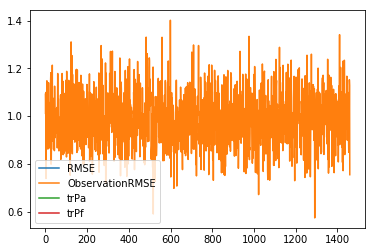

nan
9 2.0 1.1


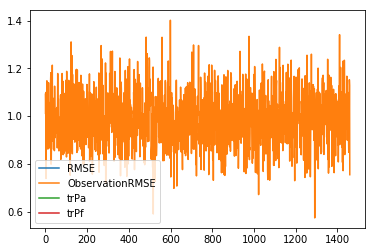

nan


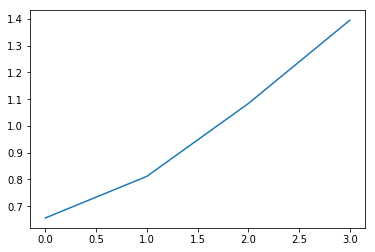

In [20]:
t = 1460
N = 40
m = 40
h = 0.05 
F = 8.0
#初期値
Xa = np.empty((N,m))
Xc = np.random.rand(N,m)
for j in range(500):
    Xb = Rungekutta4(Xc,h,F)
    Xc = Xb
Xa = Xb
#plt.plot(Xa[:,9])
#plt.plot(Xa[:,8])
#plt.show()

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
A = []
B = []
for i in range(10):
    a = 0
    a_window = i
    sigma = 2.0
    for j in range(1):
        b = 1.0+0.1
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        for k in range(t):
            
            mask = np.random.choice(40,a,replace=False)
            y_ =np.delete(Y[k],mask)
            D=np.zeros((N,N-a))
            L=np.zeros((N,N-a))
            r=0
            obs=np.arange(N)
            obs=np.delete(obs,mask)
            for s in range(N):
                for u in range(N-a):
                    D[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
            d0 = 2*np.sqrt(10/3)*sigma
            r0 = np.exp(-d0**2/(2*sigma**2))
            L = np.exp(-D**2/(2*sigma**2))
            L[L<r0]=0
            """
            for s in range(N):
                for u in range(N-a):
                    if(D[s,u]<2*np.sqrt(10/3)*sigma):
                        L[s,u] = np.exp(-D[s,u]**2/(2*sigma**2))
                    else:
                        L[s,u] = 0
            """
            L = np.eye(N)
            (Xf,Pf,dXf,Xf_) = Forecast(Xa,m,b,L)
            (Xa,Pa,Xa_) = Analysis(Xf,Pf,dXf,Xf_,y_,m,a,mask,b,L,a_window)
            #print(Xf)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k]
            Y1 = Y[k]
            rmse = np.sqrt(np.sum((Xa-X1)*(Xa-X1),axis=0)/N)
            rmsef = np.sqrt(np.sum((Xf-X1)*(Xf-X1),axis=0)/N)
            rmse_ = np.sqrt(np.sum((Xa_-X1)*(Xa_-X1))/N) 
            rmseo = np.sqrt(np.sum((Y1-X1)*(Y1-X1))/N)
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
             #   print(k)
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A.append(a_window)
        B.append(b)
        print(a_window,sigma,b)
#print(trPa)
#print(R)
#plt.plot(B,RMSE,label="RMSE")
#plt.show()
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
#plt.xlabel("observation missing")
    plt.plot(R_,label="RMSE")
    plt.plot(RO,label="ObservationRMSE")
    plt.plot(trPa,label="trPa")
    plt.plot(trPf,label="trPf")
    plt.legend()
#plt.savefig("SRF.jpg")
    plt.show()
    print(np.mean(R_[500:]))
    
plt.plot(A,RMSE,label="RMSE")
plt.show()

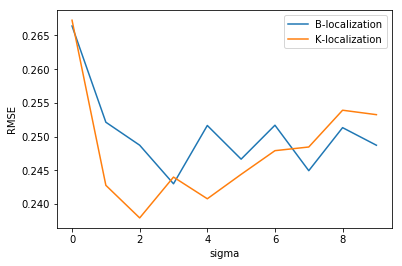

In [16]:
df1 = pd.read_csv("SRFB-localize.csv")
df2 = pd.read_csv("SRFK-localize.csv")
rmseB = df1.values
rmseK = df2.values
RB = rmseB[:,1]
RK = rmseK[:,1]
t = np.arange(1460)
plt.plot(RB,label="B-localization")
plt.plot(RK,label="K-localization")
plt.xlabel("sigma")
plt.ylabel("RMSE")
plt.legend()
plt.show()

(25, 2)
[[2.96345313 0.34794413 0.37534145 0.40860369 0.44439498]
 [2.32341121 0.33429019 0.37260342 0.39946916 0.43547068]
 [2.43593192 0.33502115 0.36237574 0.39437344 0.43092426]
 [2.95925046 0.33142383 0.36800126 0.39224439 0.42730161]
 [3.20994702 0.34047314 0.36556954 0.39673873 0.42643392]]


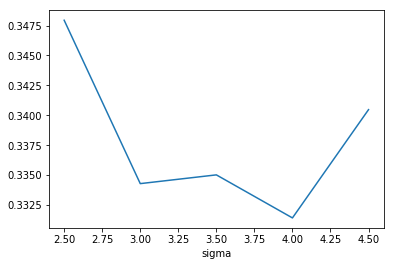

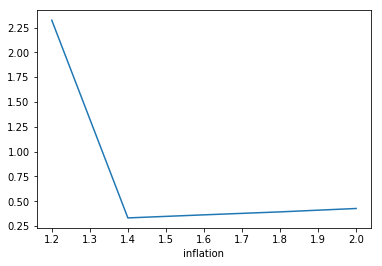

In [27]:
df=pd.read_csv("SRFm=10.csv")
rmse=df.values
print(rmse.shape)
R = rmse[:,1].reshape(5,5)
print(R)
y = [2.0+0.5*(i+1) for i in range(5)]
x = [1.0+0.2*(j+1) for j in range(5)]
Rsigma=[min(R[i,:]) for i in range(5)]
plt.plot(y,Rsigma)
plt.xlabel("sigma")
plt.show()
Rbeta = [min(R[:,i]) for i in range(5)]
plt.plot(x,Rbeta)
plt.xlabel("inflation")
plt.show()

0.35456417004836976


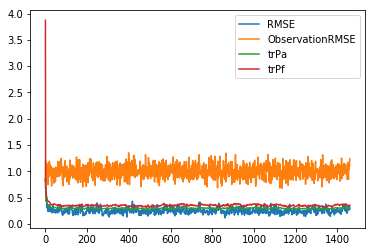

In [7]:
print(np.mean(R[500:]))
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("SRF.jpg")
plt.show()

In [69]:
#!/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv


# EnSRF



def L96(Xa,F):
    
    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb
def Forecast(Xa,m,b):
    h = 0.05 
    F = 8.0
    
    
    Xf = np.zeros((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    dXf = Xf - Xf_.reshape(-1,1)
    dXf = dXf*b
    #Zf = dXf*b/np.sqrt(m-1)
    #print(dXf)
    Pf = dXf@dXf.T/(m-1)
    
    return Xf,Pf,dXf,Xf_

def Analysis(Xf,Pf,dXf,Xf_,y,m,a,loc):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    D=np.empty((N,N))
    L=np.empty((N,N))
    obs=np.arange(N)
    obs=np.delete(obs,loc)
    for s in range(N):
        for u in range(N):
            D[s,u] = min(abs(s-u),N-abs(s-u))
    d0 = 2*np.sqrt(10/3)*sigma
    r0 = np.exp(-d0**2/(2*sigma**2))
    L = np.exp(-D**2/(2*sigma**2))
    L[L<r0]=0
    
    P0 = Pf
    dX0 = dXf
    X0_ = Xf_
    for i in range(p):
        H_ = np.reshape(H[i,:],(1,-1))
        #V1 = (H_ @ Z0).T
        D1 = H_ @ P0 @ H_.T+R[i,i]
        #print(D1)
        K1 = P0 @ H_.T @ np.linalg.inv(D1)
        K1_ = K1/(1+np.sqrt(R[i,i]/D1))
        K1_ = K1_.reshape(-1,1)
        Xa_ = X0_+K1 @ (y[i]-H_@X0_) 
        K_H = K1_ @ H_
        dXa = (I - K_H) @ dX0
        Pa = dX0@dX0.T/(m-1)
        Pa = Pa*L
        
        X0_ = Xa_
        dX0 = dXa
        P0 = Pa
        
    Xa = np.zeros((N,m))
    Xa = dXa + Xa_.reshape(-1,1)
    
    
    return Xa,Pa,Xa_



2.0 1.1


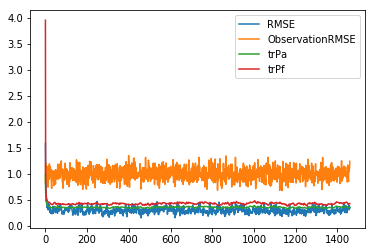

[0.29852524056774576]


In [70]:

t = 1460
N = 40
m = 10
h = 0.05 
F = 8.0
#初期値
Xa = np.zeros((N,m))
Xc = np.random.rand(N,m)
for j in range(500):
    Xb = Rungekutta4(Xc,h,F)
    Xc = Xb
Xa = Xb
#plt.plot(Xa[:,9])
#plt.plot(Xa[:,8])
#plt.show()

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
A = []
B = []
for i in range(1):
    a = 0
    sigma = 2.0
    for j in range(1):
        b = 1.1
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        for k in range(t):
            loc = np.random.choice(N,a,replace=False)
            loc.sort() 
            y = np.delete(Y[k],loc)
            
            (Xf,Pf,Zf,Xf_) = Forecast(Xa,m,b)
            (Xa,Pa,Xa_) = Analysis(Xf,Pf,Zf,Xf_,y,m,a,loc)
            #print(Xf)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k]
            Y1 = Y[k]
            rmse = np.sum((Xa-X1.reshape(-1,1))**2,axis=0)
            rmsef = np.sum((Xf-X1.reshape(-1,1))**2,axis=0)
            rmse_ = np.sum((Xa_-X1)*(Xa_-X1)) 
            rmseo = np.sum((Y1-X1)*(Y1-X1))
            rmse = np.sqrt(rmse/N)
            rmsef = np.sqrt(rmsef/N)
            rmse_ = np.sqrt(rmse_/N)
            rmseo = np.sqrt(rmseo/N)
            err = 0
            err2 = 0
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
             #   print(k)
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A.append(sigma)
        B.append(b)
        print(sigma,b)
#print(trPa)
#print(R)
#plt.plot(A,RMSE,label="RMSE")
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
#plt.xlabel("observation missing")
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("SRF.jpg")
plt.show()
print(RMSE)
#df = pd.DataFrame(RMSE)
#df.to_csv("SRFlocalize.csv")

In [6]:
print(rand(10).shape)
H = np.array([1,0,0,0,0,0,0,1,0,0,0,0,0,0,1]).reshape(3,5)
Zf=np.array([2,1,0,0,0,3,2,1,0,0]).reshape(5,2)
print(Zf)
H_=np.reshape(H[1,:],(1,-1))
print(H_)
V = (H_ @ Zf ).T
print(V)
D = V.T @ V +1
print(D)
K = Zf @ V/(D+np.sqrt(D))
print(K)
K_ = np.empty((5,0))
for i in range(3):
    K_ = np.append(K_,K,axis=1)
print(K_)

(10,)
[[2 1]
 [0 0]
 [0 3]
 [2 1]
 [0 0]]
[[0 0 1 0 0]]
[[0]
 [3]]
[[10]]
[[0.22792408]
 [0.        ]
 [0.68377223]
 [0.22792408]
 [0.        ]]
[[0.22792408 0.22792408 0.22792408]
 [0.         0.         0.        ]
 [0.68377223 0.68377223 0.68377223]
 [0.22792408 0.22792408 0.22792408]
 [0.         0.         0.        ]]


In [15]:
#LETKF
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv



def L96(Xa,F):
    
    F_ = (np.roll(Xa, -1,axis=0) - np.roll(Xa, 2,axis=0)) * np.roll(Xa, 1,axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb
def Forecast(Xa,m):
    h = 0.05 
    F = 8.0
    
    
    Xf = np.zeros((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    dXf = Xf - Xf_.reshape(-1,1)
    #print(dXf)
    Pf = dXf @ dXf.T/(m-1)
    #Pf = Pf*L
    
    return Xf,Pf,dXf,Xf_

def Analysis(dXf,Xf_,y,m,a,loc,rho,sigma):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(m)

    obs=np.arange(N)
    obs=np.delete(obs,loc)
    D = np.zeros((N,p))
    for s in range(N):
        for u in range(p):
            D[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
    #print(obs)
    Xa = np.zeros((N,m))
    Xa_ = np.zeros(N)
    dXa = np.zeros((N,m))
    #使う値は前後10点に限定
    for i in range(N):
        d = D[i]
        far = np.arange(p)
        far = far[d>2*np.sqrt(10/3)*sigma]
        yi = y
        Hi = H
        Ri = R
        yi = np.delete(yi,far)
        Hi = np.delete(Hi,far,axis=0)
        Ri = np.delete(Ri,far,axis=0)
        Ri = np.delete(Ri,far,axis=1)
        #print(yi.shape,Hi.shape,Ri.shape)
        diagR = np.diag(Ri)
        di = yi - Hi @ Xf_
        dYi = Hi @ dXf
        L = np.exp(-d**2/(2*sigma**2))
        L = np.delete(L,far)
        Ri = np.diag(diagR/L)
        R_inv = np.linalg.inv(Ri)
    
        A = (m-1)*I/rho + dYi.T @ R_inv @ dYi
        la,v = np.linalg.eigh(A) #eigenvalue decomposition
        D_inv = np.linalg.inv(np.diag(la))
        U = np.array(v).reshape(m,m)
        Pa_ = U @ D_inv @ U.T #UD^(-1)UT
        #print(Pa_)
    
        Xa_[i] = Xf_[i] + dXf[i,:] @ Pa_ @ dYi.T @ R_inv @ di 
        Pa_root = U @ np.sqrt(D_inv) @ U.T
        Pa_root = Pa_root * np.sqrt(m-1)
        dXa[i,:] = dXf[i,:] @ Pa_root
        Xa[i,:] = np.full(m,Xa_[i]) + dXa[i,:]
            
    #print("Xa_",Xa_)
    #print("dXa",dXa)
    #print("Xa",Xa)
    Pa = dXa @ dXa.T/(m-1)
    
    return Xa,Pa,Xa_

7.5 1.1


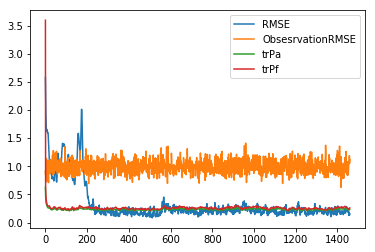

0.20738399505765207


In [16]:

t = 1460
N = 40
m = 10
h = 0.05 
F = 8.0
#初期値
Xa = np.zeros((N,m))
Xc = np.random.rand(N,m)
for j in range(500):
    Xb = Rungekutta4(Xc,h,F)
    Xc = Xb
Xa = Xb
#plt.plot(Xa[:,9])
#plt.plot(Xa[:,8])
#plt.show()

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
A = []
B = []
for i in range(1):
    a = 0
    sigma = 7.5
    for j in range(1):
        rho = 1.1
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        for k in range(t):
            loc = np.random.choice(N,a,replace=False)
            loc.sort() 
            y = np.delete(Y[k],loc)
            
            (Xf,Pf,dXf,Xf_) = Forecast(Xa,m)
            (Xa,Pa,Xa_) = Analysis(dXf,Xf_,y,m,a,loc,rho,sigma)
            #print(Xf)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k,:]
            Y1 = Y[k,:]
            rmse = np.sum((Xa-X1.reshape(-1,1))**2)
            rmsef = np.sum((Xf-X1.reshape(-1,1))**2)
            rmse_ = np.sum((Xa_-X1)*(Xa_-X1)) 
            rmseo = np.sum((Y1-X1)*(Y1-X1))
            rmse = np.sqrt(rmse/N)
            rmsef = np.sqrt(rmsef/N)
            rmse_ = np.sqrt(rmse_/N)
            rmseo = np.sqrt(rmseo/N)
            err = 0
            err2 = 0
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
             #   print(k)
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A.append(sigma)
        B.append(rho)
        print(sigma,rho)
#print(trPa)
#print(R)
#plt.plot(A,RMSE,label="RMSE")
#plt.plot(A,TrPa,label="trPa")
#plt.plot(A,TrPf,label="trPf")
#plt.xlabel("observation missing")
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObsesrvationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("SRF.jpg")
plt.show()
print(np.mean(R_[500:]))
df = pd.DataFrame(RMSE)
df.to_csv("LETKF.csv")

(25, 2)
[[4.15539931 2.95434327 0.21500586 0.22755219 0.24614635]
 [4.21407149 3.01092138 0.20878076 0.2255209  0.24242344]
 [4.39924894 3.83144179 2.45593625 0.22256237 0.23812392]
 [4.30203674 3.9040388  0.20549739 0.22333314 0.2360593 ]
 [4.44255921 3.84086317 0.21007334 0.22445782 0.23391646]]


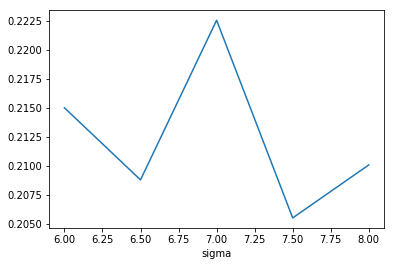

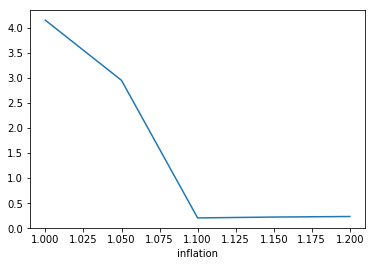

In [12]:
df=pd.read_csv("LETKF.csv")
rmse=df.values
print(rmse.shape)
R = rmse[:,1].reshape(5,5)
print(R)
x=[1.0+0.05*(j) for j in range(5)]
y = [6.0+0.5*(i) for i in range(5)]
Rsigma=[min(R[i,:]) for i in range(5)]
plt.plot(y,Rsigma)
plt.xlabel("sigma")
plt.show()
Rbeta = [min(R[:,i]) for i in range(5)]
plt.plot(x,Rbeta)
plt.xlabel("inflation")
plt.show()

(11,)


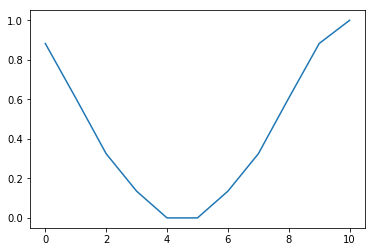

In [15]:
print(L.shape)
plt.plot(L)
plt.show()

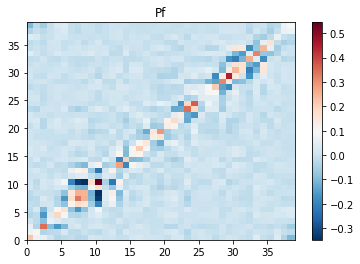

In [46]:
x = np.arange(40)
y = np.arange(40)
plt.pcolor(x,y,Pf,cmap='RdBu_r')
plt.colorbar()
plt.title("Pf")
plt.show()

[]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[[0. 1. 2. ... 3. 2. 1.]
 [1. 0. 1. ... 4. 3. 2.]
 [2. 1. 0. ... 5. 4. 3.]
 ...
 [3. 4. 5. ... 0. 1. 2.]
 [2. 3. 4. ... 1. 0. 1.]
 [1. 2. 3. ... 2. 1. 0.]]
[[1.         0.45783336 0.04393693 ... 0.         0.04393693 0.45783336]
 [0.45783336 1.         0.45783336 ... 0.         0.         0.04393693]
 [0.04393693 0.45783336 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.45783336 0.04393693]
 [0.04393693 0.         0.         ... 0.45783336 1.         0.45783336]
 [0.45783336 0.04393693 0.         ... 0.04393693 0.45783336 1.        ]]


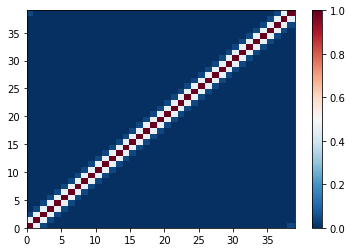

In [36]:
N=40
a=0
p=N-a
sigma=0.8
D = np.zeros((N,p))
L = np.zeros((N,p))
loc = np.random.choice(N,a,replace=False)
loc.sort()
print(loc)
r=0
obs=np.arange(N)
obs=np.delete(obs,loc)
print(obs)
for s in range(N):
    for u in range(N-a):
        D[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
print(D)        
A=D>5
#print(A)
#print(D[A])
d0=2*np.sqrt(10/3)*sigma
r0=np.exp(-d0**2/(2*sigma**2))
L=np.exp(-D**2/(2*sigma**2))
L[L<r0]=0
x=np.arange(p)
y=np.arange(N)
#P = L*Pf
print(L)
plt.pcolor(x,y,L,cmap='RdBu_r')
plt.colorbar()
#plt.title("L*Pf")
#plt.show()

#L2 = np.exp(-D/2)
#print(L2*L2)
#dX = L2*dXf
#P2 = dX @ dX.T/(m-1)
#print(P2)

In [13]:
#adaptive inflation
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv


# ETKF



def L96(Xa,F):
   
    F_ = (np.roll(Xa, -1, axis=0) - np.roll(Xa, 2, axis=0)) * np.roll(Xa, 1, axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb
def Forecast(Xa,y,m,a,A):
    h = 0.05 
    F = 8.0
    b = 0.01
    
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    Xf = np.zeros((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    dXf = Xf - Xf_.reshape(-1,1)
    Pf = dXf @ dXf.T/(m-1)
    
    #d = np.zeros((p,m))
    #for k in range(m):
    #    d[:,k] = y - H @ Xf[:,k]
    #d_ = np.sum(d,axis=1)/m
    #do = [d[:,k]-d_ for k in range(m)]
    #dob = np.array(do).reshape(m,p).T
    #B = dob @ dob.T/(m-1)
    
    d = y - H @ Xf_
    do = d.reshape(-1,1)
    trPf = np.sum(np.diag(H @ Pf @ H.T))
    trB = np.sum(np.diag(do @ do.T))
    trR = np.sum(np.diag(R))
    
    alpha_ = (trB-trR)/trPf
    #print(alpha_)
    alpha = b*alpha_+(1-b)*A
    dXf = dXf*np.sqrt(alpha)
    
    return Xf,Pf,dXf,Xf_,alpha

def Analysis(Xf,Pf,dXf,Xf_,y,m,a,loc,L):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    dY = H @ dXf
    #カルマンゲインの導出
    A = dY @ dY.T + (m-1)*R
    A_inv = np.linalg.inv(A)
    K = dXf @ dY.T @ A_inv
    K = L*K
    
    Xa_ = Xf_ + K @ (y - H @ Xf_)
    E = np.eye(m)
    TT = E - dY.T @ A_inv @ dY
    #print(TT)
    
    la,v = np.linalg.eig(TT)
    #print(v)
    D = np.diag(np.sqrt(la))
    #print(D)
    U = np.array(v).reshape(m,m)
    Q,R_=np.linalg.qr(U)
    
    T = Q @ D
    #print(T @ T.T)
    dXa = dXf @ T
    Xa = np.zeros((N,m))
    Xa = dXa + Xa_.reshape(-1,1)
    
    Pa = dXa @ dXa.T/(m-1)
    
    return Xa,Pa,Xa_



1.5 1.9948832065535584


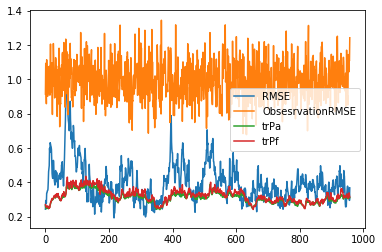

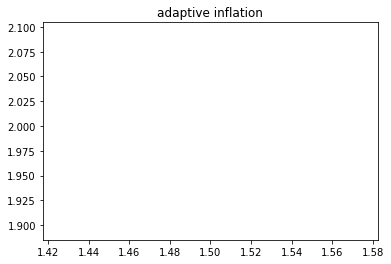

In [14]:

t = 1460
N = 40
m = 10
h = 0.01 
F = 8.0
#初期値
Xa = np.zeros((N,m))
Xc = np.random.rand(N,m)
for j in range(200):
    Xb = Rungekutta4(Xc,h,F)
    Xc = Xb
Xa = Xb
#plt.plot(Xa[:,9])
#plt.plot(Xa[:,8])
#plt.show()

dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
S = []
A_=[]
for j in range(1):
    a = 5
    sigma = 1.5
    trPa = []
    trPf = []
    R = []
    Rf = []
    R_ = []
    RO = []
    A=[]
    A.append(1.0)
    for k in range(t):
        loc = np.random.choice(N,a,replace=False)
        loc.sort() 
        y = np.delete(Y[k],loc)
        D=np.zeros((N,N-a))
        L=np.zeros((N,N-a))
        obs=np.arange(N)
        obs = np.delete(obs,loc)
        for s in range(N):
            for u in range(N-a):
                D[s,u] = min(abs(s-obs[u]),N-abs(s-obs[u]))
        d0 = 2*np.sqrt(10/3)*sigma
        r0 = np.exp(-d0**2/(2*sigma**2))
        L = np.exp(-D**2/(2*sigma**2))
        L[L<r0] = 0
        #print(L)
        (Xf,Pf,dXf,Xf_,alpha) = Forecast(Xa,y,m,a,A[-1])
        (Xa,Pa,Xa_) = Analysis(Xf,Pf,dXf,Xf_,y,m,a,loc,L)
        A.append(alpha)
        #print(Xf)
        
        if(k>500):
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k,:]
            Y1 = Y[k,:]
            rmse = np.sum((Xa-X1.reshape(-1,1))**2,axis=1)
            rmsef = np.sum((Xf-X1.reshape(-1,1))**2,axis=1)
            rmse_ = np.sum((Xa_-X1)*(Xa_-X1)) 
            rmseo = np.sum((Y1-X1)*(Y1-X1))
            rmse = np.sqrt(rmse/N)
            rmsef = np.sqrt(rmsef/N)
            rmse_ = np.sqrt(rmse_/N)
            rmseo = np.sqrt(rmseo/N)
            err = 0
            err2 = 0
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
             #   print(k)
    rb = np.sum(np.array(R_))/(t-500)
    trPab = np.sum(np.array(trPa))/(t-500)
    trPfb = np.sum(np.array(trPf))/(t-500)
    alpha_=np.sum(np.array(A))/(t)
    RMSE.append(rb)
    TrPa.append(trPab)
    TrPf.append(trPfb)
    A_.append(alpha_)
    S.append(sigma)
    print(sigma,alpha_)
#print(trPa)
#print(R_)
#KF = np.ones(np.array(S).size)*0.221851
#plt.plot(S,RMSE,label="RMSE")
#plt.plot(S,TrPa,label="trPa")
#plt.plot(S,TrPf,label="trPf")
#plt.plot(S,KF,label="KF")
#plt.xlabel("sigma")
#plt.title("SRF,m=10")
plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObsesrvationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("SRFm=10.jpg")
plt.show()
plt.plot(S,A_)
plt.title("adaptive inflation")
#plt.savefig("SRFalpham=10")
plt.show()

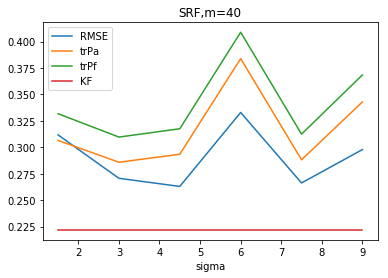

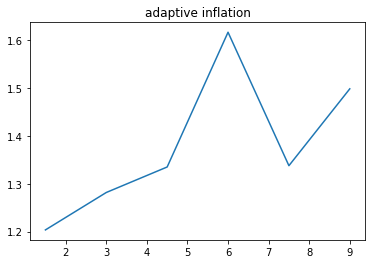

In [20]:
KF = np.ones(np.array(S).size)*0.221851
plt.plot(S,RMSE,label="RMSE")
plt.plot(S,TrPa,label="trPa")
plt.plot(S,TrPf,label="trPf")
plt.plot(S,KF,label="KF")
plt.xlabel("sigma")
plt.title("SRF,m=40")
#plt.plot(R_,label="RMSE")
#plt.plot(RO,label="ObsesrvationRMSE")
#plt.plot(trPa,label="trPa")
#plt.plot(trPf,label="trPf")
plt.legend()
plt.savefig("SRFm=40_2.jpg")
plt.show()
plt.plot(S,A_)
plt.title("adaptive inflation")
plt.savefig("SRFalpham=40_2")
plt.show()

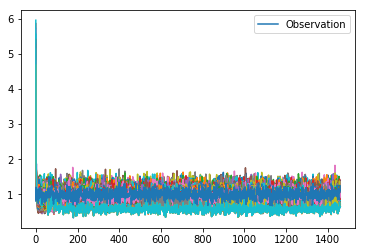

In [7]:
RMSE = np.array(R).reshape(t,m)
RMSEf = np.array(Rf).reshape(t,m)
for i in range(m):
    #plt.plot(RMSE[:,i])
    plt.plot(RMSEf[:,i])
plt.plot(RO,label="Observation")
plt.legend()
plt.show()

1.5 0.8
1.6 0.8
1.7 0.8
1.8 0.8
1.9 0.8


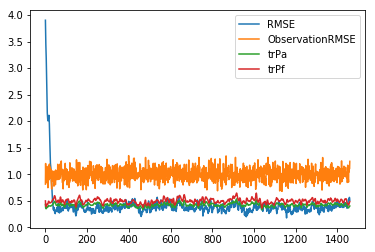

0.3724248669666783


In [45]:
#POsystem
import sys
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import random
import pandas as pd
import csv

def L96(Xa,F):
    
    F_ = (np.roll(Xa, -1, axis=0) - np.roll(Xa, 2, axis=0)) * np.roll(Xa, 1, axis=0) -  Xa + F
    
    return F_

#4次のルンゲクッタ
def Rungekutta4(Xa,h,F):
    
    F_ = L96(Xa,F)
    K1 = h*F_

    X2=Xa+K1/2
    F_ = L96(X2,F)
    K2=h*F_
    
    X3=Xa+K2/2
    F_ = L96(X3,F)
    K3=h*F_
    
    X4=Xa+K3
    F_ = L96(X4,F)
    K4=h*F_
    
    Xb=Xa+K1/6+K2/3+K3/3+K4/6
    
    return Xb
def Forecast(Xa,y,m,a,A,L):
    h = 0.05 
    F = 8.0
    N = 40
    b = 0.01
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    Xf = np.zeros((N,m))
    Xf = Rungekutta4(Xa,h,F)
    #print(Xf)
    Xf_ = np.sum(Xf,axis=1)/m
    #print(Xf_.shape)
    dXf = Xf - Xf_.reshape(-1,1)
    dXf = dXf*A
    #print(dXf)
    Pf = dXf @ dXf.T/(m-1)
    #Pf = Pf*L
    
    d = y - H @ Xf_
    do = d[:,np.newaxis]
    trPf = np.sum(np.diag(H @ Pf @ H.T))
    trB = np.sum(np.diag(do @ do.T))
    trR = np.sum(np.diag(R))
    
    alpha_ = (trB-trR)/trPf
    #print(alpha_)
    alpha = b*alpha_+(1-b)*A
    #dXf = dXf*np.sqrt(alpha)
    #Pf = Pf * alpha
    
    return Xf,Pf,dXf,Xf_,alpha

def Analysis(Xf,Pf,dXf,Xf_,y,EO,m,a,loc,L):
    N = 40
    p = N-a
    H = np.identity(N)
    H = np.delete(H,loc,axis=0) #観測行列
    R = np.eye(p)
    I = np.eye(N)
    
    Y = np.zeros((p,m))
    Y = y.reshape(-1,1) + EO
    #dY = H @ dXf
    #カルマンゲインの導出
    K = Pf @ H.T @ np.linalg.inv(H @ Pf @ H.T + R)
    K = K*L
    
    Xa = Xf + K @ (Y - H @ Xf)
    Xa_ = Xf_ + K @ (y - H @ Xf_)
    Pa = (I - K @ H)@ Pf
    
    return Xa,Xa_,Pa


t = 1460
N = 40
m = 10
h = 0.01 
F = 8.0
#初期値
Xa = np.zeros((N,m))
Xc = np.random.rand(N,m)
for j in range(500):
    Xb = Rungekutta4(Xc,h,F)
    Xc = Xb
Xa = Xb
#plt.plot(Xa[:,39])
#plt.plot(Xa[:,38])
#plt.show()

a = 0
dataset = pd.read_csv("observation_data.csv")
Y = dataset.values.reshape(t,N)
dataset2 = pd.read_csv("data.csv")
Xt = dataset2.values.reshape(t,N)
RMSE = []
TrPa = []
TrPf = []
B = []
A_=[]
for i in range(5):
    sigma = 1.5+0.1*i
    for j in range(1):
        b = 0.8
        mu = np.zeros(N-a)
        sigma2 = np.eye(N-a)
        EO = multivariate_normal(mu,sigma2,m).T
        #print(EO.shape)
        trPa = []
        trPf = []
        R = []
        Rf = []
        R_ = []
        RO = []
        A=[]
        #A.append(1.0)
        for k in range(t):
            loc = np.random.choice(N,a,replace=False)
            y = np.delete(Y[k],loc)
            D=np.zeros((N,N-a))
            L=np.zeros((N,N-a))
            obs=np.arange(N)
            obs=np.delete(obs,loc)
            for s in range(N):
                for u in range(N-a):
                    D[s,u] = min(abs(s-u),N-abs(s-u))
            d0=2*np.sqrt(10/3)*sigma
            r0=np.exp(-d0**2/(2*sigma**2))
            L = np.exp(-D**2/(2*sigma**2))
            L[L<r0]=0
        
            #(Xf,Pf,dXf,Xf_,alpha) = Forecast(Xa,y,m,a,A[-1],L)
            (Xf,Pf,dXf,Xf_,alpha) = Forecast(Xa,y,m,a,b,L)
            (Xa,Xa_,Pa) = Analysis(Xf,Pf,dXf,Xf_,y,EO,m,a,loc,L)
            A.append(alpha)
    
            rmse=np.zeros(m)
            rmsef = np.zeros(m)
            rmse_=0
            X1 = Xt[k,:]
            Y1 = Y[k,:]
            rmse = np.sum((Xa-X1.reshape(-1,1))**2)
            rmsef = np.sum((Xf-X1.reshape(-1,1))**2)
            rmse_ = np.sum((Xa_-X1)*(Xa_-X1)) 
            rmseo = np.sum((Y1-X1)*(Y1-X1))
            rmse = np.sqrt(rmse/N)
            rmsef = np.sqrt(rmsef/N)
            rmse_ = np.sqrt(rmse_/N)
            rmseo = np.sqrt(rmseo/N)
            err = 0
            err2 = 0
            err = np.sqrt(np.sum(np.diag(Pa))/N)
            err2 = np.sqrt(np.sum(np.diag(Pf))/N)
            trPa.append(abs(err))
            trPf.append(abs(err2))
            R.append(rmse)
            Rf.append(rmsef)
            R_.append(rmse_)
            RO.append(rmseo)
            #if(k%100==0):
                #print(k)
        rb = np.sum(np.array(R_[500:]))/(t-500)
        trPab = np.sum(np.array(trPa[500:]))/(t-500)
        trPfb = np.sum(np.array(trPf[500:]))/(t-500)
        alpha_=np.sum(np.array(A))/1460
        RMSE.append(rb)
        TrPa.append(trPab)
        TrPf.append(trPfb)
        A_.append(b)
        B.append(sigma)
    print(sigma,b)
#print(trPa)
#print(R)
#KF = np.ones(np.array(B).size)*0.221851
#plt.plot(B,RMSE,label="RMSE")
#plt.plot(B,TrPa,label="trPa")
#plt.plot(B,TrPf,label="trPf")
#plt.plot(B,KF,label="KF")
#plt.xlabel("sigma")
#plt.title("PO,m=10")
#plt.legend()
#plt.savefig("POm=40.jpg")
#plt.show()

#plt.plot(B,A_)
#plt.title("PO,adaptive inflation")
#plt.xlabel("sigma")
#plt.savefig("POm=40alpha.jpg")
#plt.show()

plt.plot(R_,label="RMSE")
plt.plot(RO,label="ObservationRMSE")
plt.plot(trPa,label="trPa")
plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("PO.jpg")
plt.show()
print(np.mean(R_[500:]))
df = pd.DataFrame(RMSE)
df.to_csv("PO.csv")

(5, 2)
[[0.39281353]
 [0.3670826 ]
 [0.3573747 ]
 [0.35876277]
 [0.37242487]]


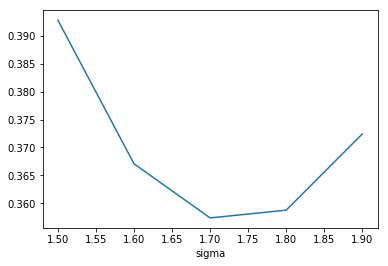

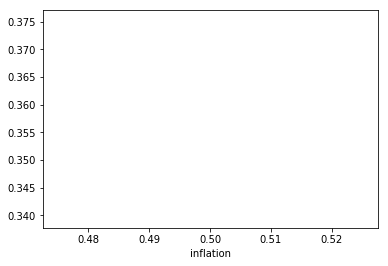

In [46]:
df=pd.read_csv("PO.csv")
rmse=df.values
print(rmse.shape)
R = rmse[:,1].reshape(5,1)
print(R)
y = [1.5+0.1*i for i in range(5)]
x = [0.5+0.1*j for j in range(1)]
Rsigma=[min(R[i,:]) for i in range(5)]
plt.plot(y,Rsigma)
plt.xlabel("sigma")
plt.show()
Rbeta = [min(R[:,i]) for i in range(1)]
plt.plot(x,Rbeta)
plt.xlabel("inflation")
plt.show()

[0.3231193839799868, 0.2965883753035106, 0.2717158055897747, 0.2770254181895041, 0.297613235963786, 0.2938469598275201, 0.2797908979698874, 0.2828170238691817, 0.29995956076901215, 0.2965493275221229]


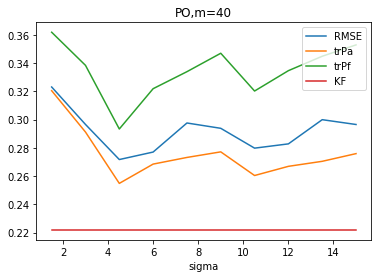

No handles with labels found to put in legend.


[0.5842270400180551, 0.9322990377001106, 1.0687999118899327, 1.1319880060612535, 1.1353684864363498, 1.2801617223699189, 1.4668051980307528, 1.3527374496481397, 1.5704765257204532, 1.5887487545544605]


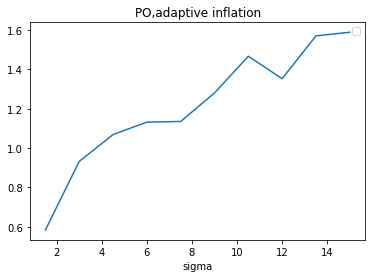

In [3]:
print(RMSE)
KF = np.ones(np.array(B).size)*0.221851
plt.plot(B,RMSE,label="RMSE")
plt.plot(B,TrPa,label="trPa")
plt.plot(B,TrPf,label="trPf")
plt.plot(B,KF,label="KF")
plt.xlabel("sigma")
plt.title("PO,m=40")
#plt.plot(R_,label="RMSE")
#plt.plot(RO,label="ObsesrvationRMSE")
#plt.plot(trPa,label="trPa")
#plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("POm=30.jpg")
plt.show()

print(A_)
plt.plot(B,A_)
plt.title("PO,adaptive inflation")
plt.xlabel("sigma")
#plt.plot(R_,label="RMSE")
#plt.plot(RO,label="ObsesrvationRMSE")
#plt.plot(trPa,label="trPa")
#plt.plot(trPf,label="trPf")
plt.legend()
#plt.savefig("POm=30alpha.jpg")
plt.show()

(9, 10)


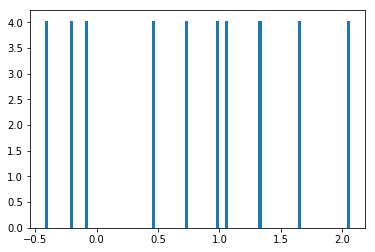

In [4]:
from numpy.random import *
from matplotlib import pyplot as plt

N=10
m=10
a=1

mu = np.zeros(N-a)
sigma = np.eye(N-a)
values = multivariate_normal(mu,sigma,m)
EO = values.T
print(EO.shape)

plt.hist(EO[2,:],bins=100,density=True)
plt.show()

In [8]:
from numpy.random import *
N=2
mu = np.zeros(N)
sigma = np.eye(N)
#values = multivariate_normal(mu,sigma,N)
values=np.array([[5,2],[2,7]])
A_inv = np.linalg.inv(values)
print(values)
(la,v) = np.linalg.eigh(values)
D = np.diag(la)
D_inv = np.linalg.inv(D)
U = np.array(v).reshape(N,N)
Q,R = np.linalg.qr(U)

I = U.T @ U
T = Q @ D
X = T @ T.T

print(A_inv)
print(U @ D_inv @ U.T)

[[5 2]
 [2 7]]
[[ 0.22580645 -0.06451613]
 [-0.06451613  0.16129032]]
[[ 0.22580645 -0.06451613]
 [-0.06451613  0.16129032]]


In [5]:
dX = [[i,i+1,i+2] for i in range(4)]
print(np.ones(np.array(dX).size))
dXf = np.array(dX).reshape(4,3).T
print(dXf)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0 1 2 3]
 [1 2 3 4]
 [2 3 4 5]]


4
